# Feature Matching & Mosaicing Images

### Environment Setup

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import random
from scipy.linalg import svd
from IPython.core.debugger import set_trace

### Class for Stitching Images using SIFT and ORB

In [2]:
class Stitcher:
    def __init__(self):
        self.algo = 'SIFT'
        
    # Detects and returns the keypoints using SIFT or FAST for the given image
    def detect_keypoints(self, input_img, n=0):
        if self.algo == 'SIFT' and n > 0:
            model = cv.SIFT_create(nfeatures=n)
        elif self.algo == 'SIFT':
            model = cv.SIFT_create()
        elif self.algo == 'FAST':
            model = fast = cv.ORB_create()
        key_points = model.detect(input_img, None)
        return key_points
    
    # Returns the image with keypoints drawn as red dots
    def draw_given_keypoints(self, input_img, output_image, key_points):
        img = cv.drawKeypoints(input_img, key_points, None, color=(255,0,0))
        output_image = 'results/' + output_image
        cv.imwrite(output_image, img)
        new_img = cv.imread(output_image)
        return new_img
    
    def extract_features(self, image, keypoints, algorithm='SIFT', n=0):
        if self.algo=='SIFT' and n>0:
            model = cv.SIFT_create(nfeatures=n)
            kp, descriptors = model.compute(image, keypoints)
        elif self.algo=='SIFT':
            model = cv.SIFT_create()
            kp, descriptors = model.compute(image, keypoints)
        elif self.algo=='FAST':
            model = cv.ORB_create()
            kp, descriptors = model.compute(image, keypoints)
        return descriptors
    
    def match_by_brute_force(self, desc1, desc2, algorithm='SIFT', n=0):
        if self.algo=='SIFT':
            bf = cv.DescriptorMatcher_create("BruteForce")
            matches = bf.knnMatch(desc1, desc2, k=2)
        elif self.algo=='FAST':
            bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
            matches = bf.match(desc1,desc2)
            matches = sorted(matches, key = lambda x:x.distance)
            if n > 0:
                good = matches[:200]
            else:
                good = matches[:int(len(matches) * 0.15)]
            matches = good
        return matches
    
    # Apply ratio test
    def apply_ratio_test(self, rawMatches):
        matches = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
                matches.append(m[0])
        return matches
    
    # Draw the correspondances and display them
    def draw_correspondences(self, ImgA, ImgB, kpA, kpB, matches):
        img3 = cv.drawMatches(ImgA, kpB, ImgB, kpB, matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img3),plt.show()
       
    # Get the x->X correspondance coordinates
    def generate_2d_correspondances(self, matches, kpA, kpB):
        x_list = []
        X_list = []
        for desc in matches:
            x_list.append(kpA[desc.queryIdx].pt)
            X_list.append(kpB[desc.trainIdx].pt)
        x = np.array(x_list)
        x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
        X = np.array(X_list)
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        return (x, X)
    
    # Normalixe the points to a normal distribution with mean as center and std deviation as the limit
    def normalize_points(self, dimension, x):
        m, s = np.mean(x,axis=0), np.std(x)

        if dimension == 2:
            Tr = np.array([[s, 0, m[0]], [0, s, m[1]], [0, 0, 1]])
        else:
            Tr = np.array([[s, 0, 0, m[0]], [0, s, 0, m[1]], [0, 0, s, m[2]], [0, 0, 0, 1]])

        Tr = np.linalg.inv(Tr) #Why?
        x = np.dot(Tr,np.concatenate((x.T,np.ones((1,x.shape[0])))))
        x = x[0:dimension, :].T
        x = np.concatenate((np.array(x), np.ones((x.shape[0],1))), axis=1)

        return Tr,x
    
    def find_homography(self, p1, p2):
        A_list = []
        for i in range(p1.shape[0]):
            A_list.append([0, 0, 0, -p2[i][2]*p1[i][0], -p2[i][2]*p1[i][1], -p2[i][2]*p1[i][2], p2[i][1]*p1[i][0], p2[i][1]*p1[i][1], p2[i][1]*p1[i][2]])
            A_list.append([p2[i][2]*p1[i][0], p2[i][2]*p1[i][1], p2[i][2]*p1[i][2], 0, 0, 0, -p2[i][0]*p1[i][0], -p2[i][0]*p1[i][1], -p2[i][0]*p1[i][2]])
            A_list.append([-p2[i][1]*p1[i][0], -p2[i][1]*p1[i][1], -p2[i][1]*p1[i][2], p2[i][0]*p1[i][0], p2[i][0]*p1[i][1], p2[i][0]*p1[i][2], 0, 0, 0])
        A = np.array(A_list)
        U,s,Vt = svd(A,full_matrices = False, overwrite_a = True)
        del U,s
        h = Vt[-1]
        H = h.reshape(3,3)
        return H
    
    # Estimate the best Homography
    def ransac(self, points1, points2, thresh=0.55, t=6, N=1000):
        maxInliers = []
        correspondances = points1.shape[0]
        T = correspondances*thresh
        finalH = None

        for i in range(N):
            #find 4 random points to calculate a homography
            index1 = random.randrange(0, points1.shape[0])

            p1_list = []
            p2_list = []
            for j in range(5):
                select_index = random.randrange(0, points1.shape[0])
                p1_list.append(points1[select_index, :])
                p2_list.append(points2[select_index, :])

            p1 = np.array(p1_list)
            p2 = np.array(p2_list)

            #call the homography function on those points
            h = self.find_homography(p1,p2)
            inliers = []

            distances = []
            for k in range(points1.shape[0]):
                d = self.geometricDistance(points1[k, :], points2[k, :], h)
                
                if d < t:
                    inliers.append(points1[k, :])
                    inliers.append(points2[k, :])
                distances.append(d)

            if len(inliers) > len(maxInliers):
                maxInliers = inliers
                finalH = h
            print("Iteration: ", i, "Total points: ", correspondances, " NumInliers: ", len(inliers)/2, "Max inliers: ", len(maxInliers)/2, "T: ", T, "Avg. distance: ", np.mean(distances))

            if len(maxInliers)/2 > T:
                break
        return finalH, maxInliers
    
    # Calculate the geometric distance
    def geometricDistance(self, p1, p2, h):

        estimatep2 = h.dot(p1)
        estimatep2 = (1/estimatep2.item(2))*estimatep2

        error = p2 - estimatep2
        return np.linalg.norm(error)
    
    def warpImages(self, ImgA, ImgB, H, outputName):
        result = cv.warpPerspective(ImgA, H, (ImgB.shape[1] + ImgA.shape[1], ImgA.shape[0]))
        result[0:ImgB.shape[0], 0:ImgB.shape[1]] = ImgB
        status = cv.imwrite(outputName, result)
        return status

### Helper Functions

In [3]:
def read_and_display_rgb_image(filename, img_title):
    I = cv.imread(filename)
    I_rgb = cv.cvtColor(I, cv.COLOR_BGR2RGB)

    img_title = img_title + '(RGB)'
    display_image(I_rgb, img_title)
    
    return I

def display_image(img, img_title):
    plt.imshow(img)
    plt.title(img_title)
    plt.show()

## SIFT Implementation

### Stitch Middle and Right Image

#### Check correspondances for all keypoints

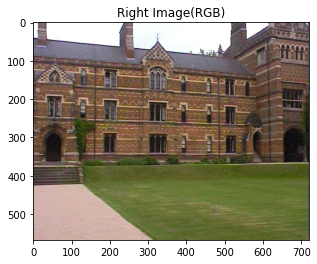

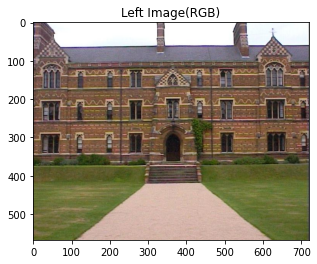

Number of Keypoints for images are:  4012 and  4188


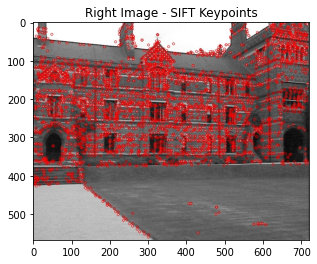

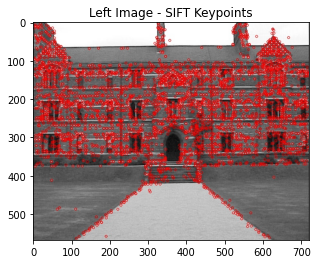

Number of Descriptors for images are:  (4012, 128) and  (4188, 128)
Number of Descriptors for images are:  (4012, 128) and  (4188, 128)
Total good matches after Bruteforce and Ratio Test are:  946


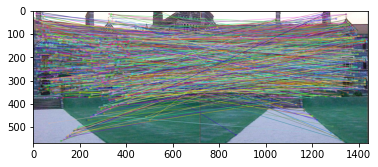

In [12]:
ImgA = read_and_display_rgb_image('images/keble_c.jpg', 'Right Image')
ImgB = read_and_display_rgb_image('images/keble_b.jpg', 'Left Image')
stitcher = Stitcher()
kpA = stitcher.detect_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY))
kpB = stitcher.detect_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY))
print("Number of Keypoints for images are: ", len(kpA), "and ", len(kpB))
ImgA_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), 'keble_c_sift_kps.jpg', kpA)
display_image(ImgA_kps, 'Right Image - SIFT Keypoints')
ImgB_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), 'keble_b_sift_kps.jpg', kpB)
display_image(ImgB_kps, 'Left Image - SIFT Keypoints')
descA = stitcher.extract_features(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), kpA)
descB = stitcher.extract_features(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), kpB)
print("Number of Descriptors for images are: ", descA.shape, "and ", descB.shape)
print("Number of Descriptors for images are: ", descA.shape, "and ", descB.shape)
rawMatches = stitcher.match_by_brute_force(descA, descB)
matches = stitcher.apply_ratio_test(rawMatches)
print("Total good matches after Bruteforce and Ratio Test are: ", len(matches))
stitcher.draw_correspondences(ImgA, ImgB, kpA, kpB, matches)

#### Stitch using the top 200 keypoints

Number of Keypoints for images are:  200 and  201


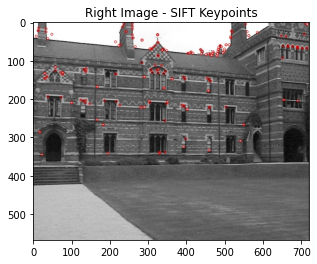

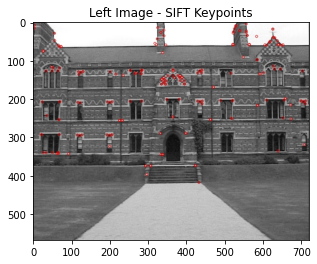

Number of Descriptors for images are:  (200, 128) and  (201, 128)
Total good matches after Bruteforce and Ratio Test are:  60


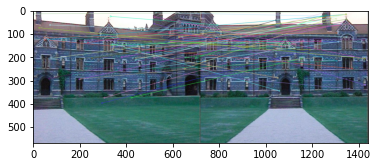

The input points are:  (60, 3) and  (60, 3)
Iteration:  0 Total points:  60  NumInliers:  0.0 Max inliers:  0.0 T:  36.0 Avg. distance:  239.08258515823073
Iteration:  1 Total points:  60  NumInliers:  40.0 Max inliers:  40.0 T:  36.0 Avg. distance:  51.61004627947057
The final Homography matrix is: 
 [[-2.77519089e-03 -2.14547241e-04 -9.96690668e-01]
 [ 3.61392221e-04 -3.02427959e-03 -8.11168653e-02]
 [ 7.05459428e-07 -7.69048040e-08 -3.27748929e-03]]
Correct and Incorrect matches are:  40.0 and  20.0


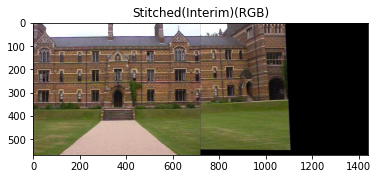

In [13]:
kpA = stitcher.detect_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), n=200)
kpB = stitcher.detect_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), n=200)
print("Number of Keypoints for images are: ", len(kpA), "and ", len(kpB))
ImgA_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), 'keble_c_sift_kps.jpg', kpA)
display_image(ImgA_kps, 'Right Image - SIFT Keypoints')
ImgB_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), 'keble_b_sift_kps.jpg', kpB)
display_image(ImgB_kps, 'Left Image - SIFT Keypoints')
descA = stitcher.extract_features(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), kpA, n=200)
descB = stitcher.extract_features(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), kpB, n=200)
print("Number of Descriptors for images are: ", descA.shape, "and ", descB.shape)
rawMatches = stitcher.match_by_brute_force(descA, descB)
matches = stitcher.apply_ratio_test(rawMatches)
print("Total good matches after Bruteforce and Ratio Test are: ", len(matches))
stitcher.draw_correspondences(ImgA, ImgB, kpA, kpB, matches)
(x, X) = stitcher.generate_2d_correspondances(matches, kpA, kpB)
print("The input points are: ", x.shape, "and ", X.shape)
H, inliers = stitcher.ransac(x, X, thresh = 0.60, t = 5)
print("The final Homography matrix is: \n", H)
correct_matches = len(inliers)/2
print("Correct and Incorrect matches are: ", correct_matches, "and ", len(matches)-correct_matches )
wstatus = stitcher.warpImages(ImgA, ImgB, H, 'results/sift-stitched-bc.jpg' )
if wstatus is True:
    stitched = read_and_display_rgb_image('results/sift-stitched-bc.jpg', 'Stitched(Interim)')

### Stitch the left image with the stitched interim image(middle + right)

#### Use the top 200 keypoints

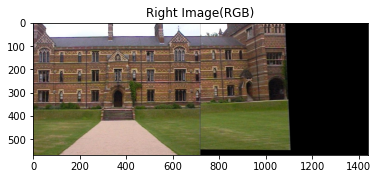

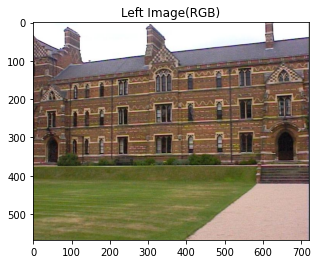

Number of Keypoints for images are:  200 and  200


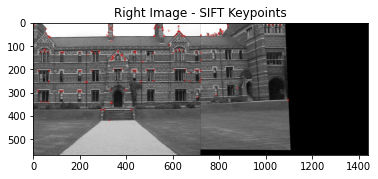

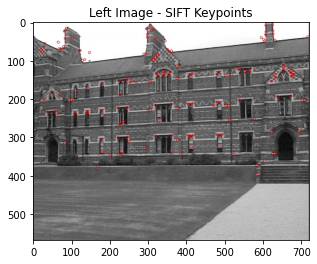

Number of Descriptors for images are:  (200, 128) and  (200, 128)
Total good matches after Bruteforce and Ratio Test are:  48
The input points are:  (48, 3) and  (48, 3)
Iteration:  0 Total points:  48  NumInliers:  30.0 Max inliers:  30.0 T:  28.799999999999997 Avg. distance:  94.45970252395551
The final Homography matrix is: 
 [[-2.90150134e-03  3.72069835e-05 -9.96667731e-01]
 [ 3.04933087e-04 -3.10665512e-03 -8.13856218e-02]
 [ 6.33951686e-07  3.24730478e-07 -3.41311991e-03]]
Correct and Incorrect matches are:  30.0 and  18.0


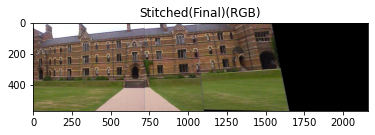

In [14]:
ImgA = read_and_display_rgb_image('results/sift-stitched-bc.jpg', 'Right Image')
ImgB = read_and_display_rgb_image('images/keble_a.jpg', 'Left Image')
kpA = stitcher.detect_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), n=200)
kpB = stitcher.detect_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), n=200)
print("Number of Keypoints for images are: ", len(kpA), "and ", len(kpB))
ImgA_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), 'stitched-bc_sift_kps.jpg', kpA)
display_image(ImgA_kps, 'Right Image - SIFT Keypoints')
ImgB_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), 'keble_a_sift_kps.jpg', kpB)
display_image(ImgB_kps, 'Left Image - SIFT Keypoints')
descA = stitcher.extract_features(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), kpA, n=200)
descB = stitcher.extract_features(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), kpB, n=200)
print("Number of Descriptors for images are: ", descA.shape, "and ", descB.shape)
rawMatches = stitcher.match_by_brute_force(descA, descB)
matches = stitcher.apply_ratio_test(rawMatches)
print("Total good matches after Bruteforce and Ratio Test are: ", len(matches))
(x, X) = stitcher.generate_2d_correspondances(matches, kpA, kpB)
print("The input points are: ", x.shape, "and ", X.shape)
H, inliers = stitcher.ransac(x, X, thresh = 0.60, t = 5)
print("The final Homography matrix is: \n", H)
correct_matches = len(inliers)/2
print("Correct and Incorrect matches are: ", correct_matches, "and ", len(matches)-correct_matches )
wstatus = stitcher.warpImages(ImgA, ImgB, H, 'results/sift-stitched.jpg' )
if wstatus is True:
    stitched = read_and_display_rgb_image('results/sift-stitched.jpg', 'Stitched(Final)')

## ORB Implementation

#### Instantiate the class and set the algo='FAST'

In [15]:
stitcher = Stitcher()
stitcher.algo = 'FAST'
stitcher.algo

'FAST'

### Stitch Middle and Right Image

#### Check correspondances for all keypoints

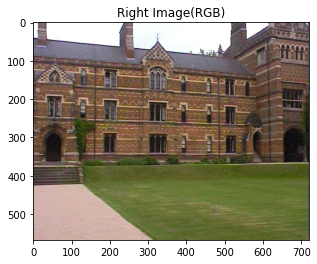

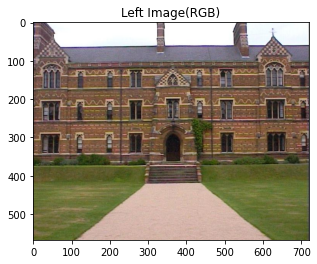

Number of Keypoints for images are:  500 and  500


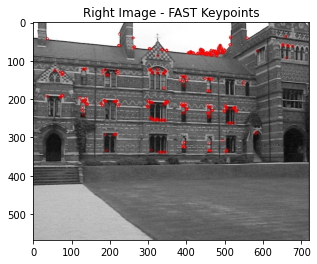

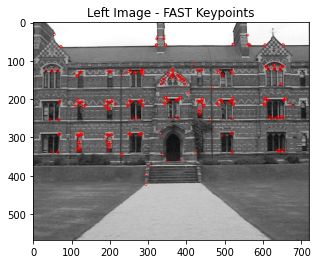

Number of Descriptors for images are:  (500, 32) and  (500, 32)
Number of Descriptors for images are:  (500, 32) and  (500, 32)
Total good matches after Bruteforce and Ratio Test are:  30


In [16]:
ImgA = read_and_display_rgb_image('images/keble_c.jpg', 'Right Image')
ImgB = read_and_display_rgb_image('images/keble_b.jpg', 'Left Image')
kpA = stitcher.detect_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY))
kpB = stitcher.detect_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY))
print("Number of Keypoints for images are: ", len(kpA), "and ", len(kpB))
ImgA_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), 'keble_c_fast_kps.jpg', kpA)
display_image(ImgA_kps, 'Right Image - FAST Keypoints')
ImgB_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), 'keble_b_fast_kps.jpg', kpB)
display_image(ImgB_kps, 'Left Image - FAST Keypoints')
descA = stitcher.extract_features(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), kpA)
descB = stitcher.extract_features(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), kpB)
print("Number of Descriptors for images are: ", descA.shape, "and ", descB.shape)
print("Number of Descriptors for images are: ", descA.shape, "and ", descB.shape)
matches = stitcher.match_by_brute_force(descA, descB)
print("Total good matches after Bruteforce and Ratio Test are: ", len(matches))
# stitcher.draw_correspondences(ImgA, ImgB, kpA, kpB, matches)

#### Use the top 200 keypoints

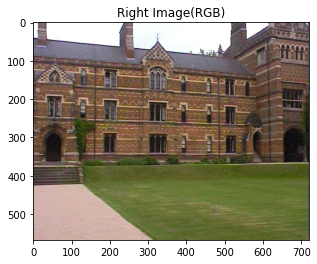

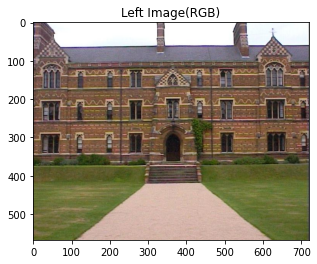

Number of Keypoints for images are:  500 and  500


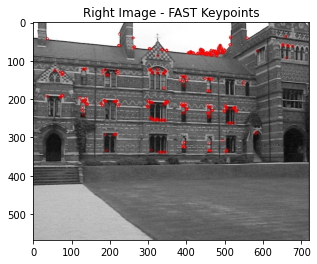

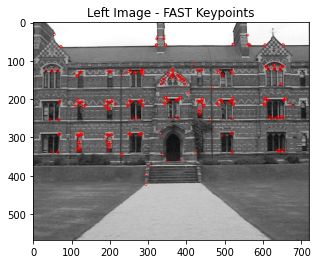

Number of Descriptors for images are:  (500, 32) and  (500, 32)
Number of Descriptors for images are:  (500, 32) and  (500, 32)
Total good matches after Bruteforce and Ratio Test are:  200
The input points are:  (200, 3) and  (200, 3)
Iteration:  0 Total points:  200  NumInliers:  0.0 Max inliers:  0.0 T:  120.0 Avg. distance:  200.07930559393301
Iteration:  1 Total points:  200  NumInliers:  0.0 Max inliers:  0.0 T:  120.0 Avg. distance:  492.3202558677198
Iteration:  2 Total points:  200  NumInliers:  4.0 Max inliers:  4.0 T:  120.0 Avg. distance:  225.07646704545462
Iteration:  3 Total points:  200  NumInliers:  0.0 Max inliers:  4.0 T:  120.0 Avg. distance:  235.11690063395
Iteration:  4 Total points:  200  NumInliers:  5.0 Max inliers:  5.0 T:  120.0 Avg. distance:  695.269589571551
Iteration:  5 Total points:  200  NumInliers:  4.0 Max inliers:  5.0 T:  120.0 Avg. distance:  464.57739175148293
Iteration:  6 Total points:  200  NumInliers:  0.0 Max inliers:  5.0 T:  120.0 Avg. dis

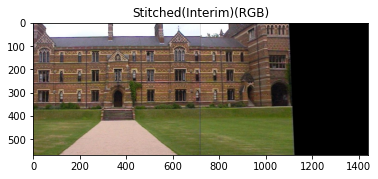

In [17]:
ImgA = read_and_display_rgb_image('images/keble_c.jpg', 'Right Image')
ImgB = read_and_display_rgb_image('images/keble_b.jpg', 'Left Image')
kpA = stitcher.detect_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY))
kpB = stitcher.detect_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY))
print("Number of Keypoints for images are: ", len(kpA), "and ", len(kpB))
ImgA_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), 'keble_c_fast_kps.jpg', kpA)
display_image(ImgA_kps, 'Right Image - FAST Keypoints')
ImgB_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), 'keble_b_fast_kps.jpg', kpB)
display_image(ImgB_kps, 'Left Image - FAST Keypoints')
descA = stitcher.extract_features(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), kpA)
descB = stitcher.extract_features(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), kpB)
print("Number of Descriptors for images are: ", descA.shape, "and ", descB.shape)
print("Number of Descriptors for images are: ", descA.shape, "and ", descB.shape)
matches = stitcher.match_by_brute_force(descA, descB, n=200)
print("Total good matches after Bruteforce and Ratio Test are: ", len(matches))
(x, X) = stitcher.generate_2d_correspondances(matches, kpA, kpB)
print("The input points are: ", x.shape, "and ", X.shape)
H, inliers = stitcher.ransac(x, X, thresh = 0.60, t = 5)
print("The final Homography matrix is: \n", H)
correct_matches = len(inliers)/2
print("Correct and Incorrect matches are: ", correct_matches, "and ", len(matches)-correct_matches )
wstatus = stitcher.warpImages(ImgA, ImgB, H, 'results/fast-stitched-bc.jpg' )
if wstatus is True:
    stitched = read_and_display_rgb_image('results/fast-stitched-bc.jpg', 'Stitched(Interim)')

### Stitch the left image with the stitched interim image(middle + right)

#### Use the top 200 keypoints

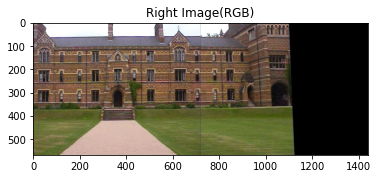

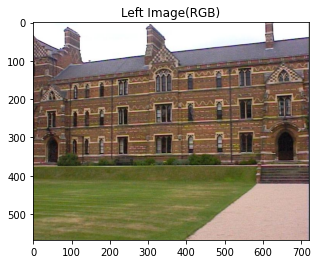

Number of Keypoints for images are:  500 and  500


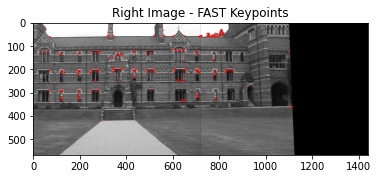

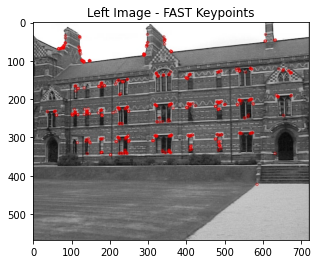

Number of Descriptors for images are:  (500, 32) and  (500, 32)
Number of Descriptors for images are:  (500, 32) and  (500, 32)
Total good matches after Bruteforce and Ratio Test are:  187
The input points are:  (187, 3) and  (187, 3)
Iteration:  0 Total points:  187  NumInliers:  0.0 Max inliers:  0.0 T:  112.2 Avg. distance:  325.5785573194874
Iteration:  1 Total points:  187  NumInliers:  0.0 Max inliers:  0.0 T:  112.2 Avg. distance:  1158.2775217034284
Iteration:  2 Total points:  187  NumInliers:  5.0 Max inliers:  5.0 T:  112.2 Avg. distance:  204.01724045280062
Iteration:  3 Total points:  187  NumInliers:  0.0 Max inliers:  5.0 T:  112.2 Avg. distance:  180.9498926795029
Iteration:  4 Total points:  187  NumInliers:  0.0 Max inliers:  5.0 T:  112.2 Avg. distance:  368.0136866522289
Iteration:  5 Total points:  187  NumInliers:  6.0 Max inliers:  6.0 T:  112.2 Avg. distance:  347.7763933315987
Iteration:  6 Total points:  187  NumInliers:  5.0 Max inliers:  6.0 T:  112.2 Avg. d

Iteration:  92 Total points:  187  NumInliers:  2.0 Max inliers:  106.0 T:  112.2 Avg. distance:  1487.694679523863
Iteration:  93 Total points:  187  NumInliers:  2.0 Max inliers:  106.0 T:  112.2 Avg. distance:  301.77661616401
Iteration:  94 Total points:  187  NumInliers:  1.0 Max inliers:  106.0 T:  112.2 Avg. distance:  1321.2158762918593
Iteration:  95 Total points:  187  NumInliers:  1.0 Max inliers:  106.0 T:  112.2 Avg. distance:  234.59627649663466
Iteration:  96 Total points:  187  NumInliers:  1.0 Max inliers:  106.0 T:  112.2 Avg. distance:  486.3382205527815
Iteration:  97 Total points:  187  NumInliers:  1.0 Max inliers:  106.0 T:  112.2 Avg. distance:  960.9000128348399
Iteration:  98 Total points:  187  NumInliers:  0.0 Max inliers:  106.0 T:  112.2 Avg. distance:  216.30782801455433
Iteration:  99 Total points:  187  NumInliers:  1.0 Max inliers:  106.0 T:  112.2 Avg. distance:  382.4592034034376
Iteration:  100 Total points:  187  NumInliers:  1.0 Max inliers:  106.

Iteration:  212 Total points:  187  NumInliers:  35.0 Max inliers:  106.0 T:  112.2 Avg. distance:  2386.3214807289983
Iteration:  213 Total points:  187  NumInliers:  0.0 Max inliers:  106.0 T:  112.2 Avg. distance:  522.5234588085021
Iteration:  214 Total points:  187  NumInliers:  1.0 Max inliers:  106.0 T:  112.2 Avg. distance:  1492.0052114853015
Iteration:  215 Total points:  187  NumInliers:  2.0 Max inliers:  106.0 T:  112.2 Avg. distance:  286.27700189297803
Iteration:  216 Total points:  187  NumInliers:  1.0 Max inliers:  106.0 T:  112.2 Avg. distance:  210.36948666218404
Iteration:  217 Total points:  187  NumInliers:  80.0 Max inliers:  106.0 T:  112.2 Avg. distance:  316.1542877873249
Iteration:  218 Total points:  187  NumInliers:  4.0 Max inliers:  106.0 T:  112.2 Avg. distance:  523.3209905308365
Iteration:  219 Total points:  187  NumInliers:  3.0 Max inliers:  106.0 T:  112.2 Avg. distance:  254.11586992000525
Iteration:  220 Total points:  187  NumInliers:  0.0 Max 

Iteration:  341 Total points:  187  NumInliers:  2.0 Max inliers:  106.0 T:  112.2 Avg. distance:  293.9629594716404
Iteration:  342 Total points:  187  NumInliers:  4.0 Max inliers:  106.0 T:  112.2 Avg. distance:  187.30265722107518
Iteration:  343 Total points:  187  NumInliers:  1.0 Max inliers:  106.0 T:  112.2 Avg. distance:  1153.487854464744
Iteration:  344 Total points:  187  NumInliers:  0.0 Max inliers:  106.0 T:  112.2 Avg. distance:  419.3538495954254
Iteration:  345 Total points:  187  NumInliers:  0.0 Max inliers:  106.0 T:  112.2 Avg. distance:  862.0748017241364
Iteration:  346 Total points:  187  NumInliers:  1.0 Max inliers:  106.0 T:  112.2 Avg. distance:  2155.9908761817155
Iteration:  347 Total points:  187  NumInliers:  1.0 Max inliers:  106.0 T:  112.2 Avg. distance:  169.44925314647267
Iteration:  348 Total points:  187  NumInliers:  5.0 Max inliers:  106.0 T:  112.2 Avg. distance:  1973.5814297821432
Iteration:  349 Total points:  187  NumInliers:  5.0 Max inl

Iteration:  470 Total points:  187  NumInliers:  0.0 Max inliers:  106.0 T:  112.2 Avg. distance:  373.3362720870057
Iteration:  471 Total points:  187  NumInliers:  0.0 Max inliers:  106.0 T:  112.2 Avg. distance:  303.10197411245497
Iteration:  472 Total points:  187  NumInliers:  1.0 Max inliers:  106.0 T:  112.2 Avg. distance:  706.2425445013776
Iteration:  473 Total points:  187  NumInliers:  5.0 Max inliers:  106.0 T:  112.2 Avg. distance:  860.4108983632775
Iteration:  474 Total points:  187  NumInliers:  0.0 Max inliers:  106.0 T:  112.2 Avg. distance:  1470.2670383626603
Iteration:  475 Total points:  187  NumInliers:  0.0 Max inliers:  106.0 T:  112.2 Avg. distance:  386.20877002741446
Iteration:  476 Total points:  187  NumInliers:  0.0 Max inliers:  106.0 T:  112.2 Avg. distance:  6020.997178075983
Iteration:  477 Total points:  187  NumInliers:  108.0 Max inliers:  108.0 T:  112.2 Avg. distance:  278.94686603536024
Iteration:  478 Total points:  187  NumInliers:  1.0 Max i

Iteration:  597 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  408.79081283464393
Iteration:  598 Total points:  187  NumInliers:  2.0 Max inliers:  108.0 T:  112.2 Avg. distance:  310.6005151323954
Iteration:  599 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  1170.980036067359
Iteration:  600 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  189.2819373685662
Iteration:  601 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  430.49658782156934
Iteration:  602 Total points:  187  NumInliers:  3.0 Max inliers:  108.0 T:  112.2 Avg. distance:  507.4300548870492
Iteration:  603 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  638.9467298070012
Iteration:  604 Total points:  187  NumInliers:  2.0 Max inliers:  108.0 T:  112.2 Avg. distance:  198.47692635574853
Iteration:  605 Total points:  187  NumInliers:  0.0 Max inli

Iteration:  729 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  309.6194427283456
Iteration:  730 Total points:  187  NumInliers:  5.0 Max inliers:  108.0 T:  112.2 Avg. distance:  212.2691464348829
Iteration:  731 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  206.14366756506837
Iteration:  732 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  890.9740734510124
Iteration:  733 Total points:  187  NumInliers:  1.0 Max inliers:  108.0 T:  112.2 Avg. distance:  2967.786639847361
Iteration:  734 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  266.21732893866033
Iteration:  735 Total points:  187  NumInliers:  103.0 Max inliers:  108.0 T:  112.2 Avg. distance:  294.41665564410175
Iteration:  736 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  467.9754585053621
Iteration:  737 Total points:  187  NumInliers:  90.0 Max i

Iteration:  818 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  694.4844882367587
Iteration:  819 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  335.63937553657786
Iteration:  820 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  302.5951056797658
Iteration:  821 Total points:  187  NumInliers:  3.0 Max inliers:  108.0 T:  112.2 Avg. distance:  218.48104002716212
Iteration:  822 Total points:  187  NumInliers:  2.0 Max inliers:  108.0 T:  112.2 Avg. distance:  493.72366408602693
Iteration:  823 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  362.7270856406791
Iteration:  824 Total points:  187  NumInliers:  2.0 Max inliers:  108.0 T:  112.2 Avg. distance:  687.11238329004
Iteration:  825 Total points:  187  NumInliers:  106.0 Max inliers:  108.0 T:  112.2 Avg. distance:  266.0888263562019
Iteration:  826 Total points:  187  NumInliers:  0.0 Max inli

Iteration:  907 Total points:  187  NumInliers:  3.0 Max inliers:  108.0 T:  112.2 Avg. distance:  211.2144779239782
Iteration:  908 Total points:  187  NumInliers:  5.0 Max inliers:  108.0 T:  112.2 Avg. distance:  238.44482599890276
Iteration:  909 Total points:  187  NumInliers:  1.0 Max inliers:  108.0 T:  112.2 Avg. distance:  237.73440522357808
Iteration:  910 Total points:  187  NumInliers:  8.0 Max inliers:  108.0 T:  112.2 Avg. distance:  520.2514040427764
Iteration:  911 Total points:  187  NumInliers:  106.0 Max inliers:  108.0 T:  112.2 Avg. distance:  286.59757622529827
Iteration:  912 Total points:  187  NumInliers:  8.0 Max inliers:  108.0 T:  112.2 Avg. distance:  255.07616152288105
Iteration:  913 Total points:  187  NumInliers:  1.0 Max inliers:  108.0 T:  112.2 Avg. distance:  340.21752355048443
Iteration:  914 Total points:  187  NumInliers:  0.0 Max inliers:  108.0 T:  112.2 Avg. distance:  345.27046199465985
Iteration:  915 Total points:  187  NumInliers:  0.0 Max

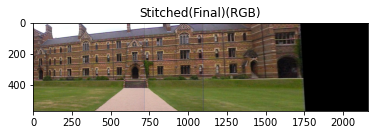

In [18]:
ImgA = read_and_display_rgb_image('results/fast-stitched-bc.jpg', 'Right Image')
ImgB = read_and_display_rgb_image('images/keble_a.jpg', 'Left Image')
kpA = stitcher.detect_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY))
kpB = stitcher.detect_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY))
print("Number of Keypoints for images are: ", len(kpA), "and ", len(kpB))
ImgA_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), 'keble_bc_fast_kps.jpg', kpA)
display_image(ImgA_kps, 'Right Image - FAST Keypoints')
ImgB_kps = stitcher.draw_given_keypoints(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), 'keble_a_fast_kps.jpg', kpB)
display_image(ImgB_kps, 'Left Image - FAST Keypoints')
descA = stitcher.extract_features(cv.cvtColor(ImgA,cv.COLOR_BGR2GRAY), kpA)
descB = stitcher.extract_features(cv.cvtColor(ImgB,cv.COLOR_BGR2GRAY), kpB)
print("Number of Descriptors for images are: ", descA.shape, "and ", descB.shape)
print("Number of Descriptors for images are: ", descA.shape, "and ", descB.shape)
matches = stitcher.match_by_brute_force(descA, descB, n=200)
print("Total good matches after Bruteforce and Ratio Test are: ", len(matches))
(x, X) = stitcher.generate_2d_correspondances(matches, kpA, kpB)
print("The input points are: ", x.shape, "and ", X.shape)
H, inliers = stitcher.ransac(x, X, thresh = 0.60, t = 5)
print("The final Homography matrix is: \n", H)
correct_matches = len(inliers)/2
print("Correct and Incorrect matches are: ", correct_matches, "and ", len(matches)-correct_matches )
wstatus = stitcher.warpImages(ImgA, ImgB, H, 'results/fast-stitched.jpg' )
if wstatus is True:
    stitched = read_and_display_rgb_image('results/fast-stitched.jpg', 'Stitched(Final)')